# Projet 8: Fruits
L'objectif de ce projet est de déployer un simple pipeline de preprocessing de données afin de de préparer pour la mise à l'echelle pour le Big data

## Import des librairies

In [1]:
from PIL import Image
from io import BytesIO
from time import time
import matplotlib
import pandas as pd
import numpy as np
import io
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

from pyspark.ml.feature import StandardScaler, PCA

from pyspark.sql.functions import col, pandas_udf, PandasUDFType, udf,split
from pyspark.ml import Pipeline

from matplotlib import pyplot as plt

import numpy as np
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1662488060805_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Import des images depuis S3
Et observation du preprocessing suivant avant réduction de dimension

In [2]:
s3path = "s3a://p8-bucket-mb/fruits360/fruit_s3/"

imgS3 = spark.read.format("binaryFile")\
.option("pathGlobFilter", "*.jpg")\
.option("recursiveFileLookup", "true").load(s3path).toDF('path', 'modificationTime', 'length', 'content')
print(type(imgS3))
print(imgS3.printSchema())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pyspark.sql.dataframe.DataFrame'>
root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)

None

In [5]:
imgS3.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3a://p8-bucket-m...|2022-08-29 14:04:41|  5656|[FF D8 FF E0 00 1...|
|s3a://p8-bucket-m...|2022-08-29 14:04:41|  5499|[FF D8 FF E0 00 1...|
|s3a://p8-bucket-m...|2022-08-29 14:04:41|  5473|[FF D8 FF E0 00 1...|
|s3a://p8-bucket-m...|2022-08-29 14:04:41|  5454|[FF D8 FF E0 00 1...|
|s3a://p8-bucket-m...|2022-08-29 14:04:42|  5319|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows

In [3]:
imgS3 = imgS3.withColumn("label", split(imgS3.path, '/')[5]).select(['path', 'content', 'label'])
imgS3.show(3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-----+
|                path|             content|label|
+--------------------+--------------------+-----+
|s3a://p8-bucket-m...|[FF D8 FF E0 00 1...|pomme|
|s3a://p8-bucket-m...|[FF D8 FF E0 00 1...|pomme|
|s3a://p8-bucket-m...|[FF D8 FF E0 00 1...|pomme|
+--------------------+--------------------+-----+
only showing top 3 rows

In [7]:
imgS3.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

20

In [15]:
imagetest=imgS3.collect()[0][1]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

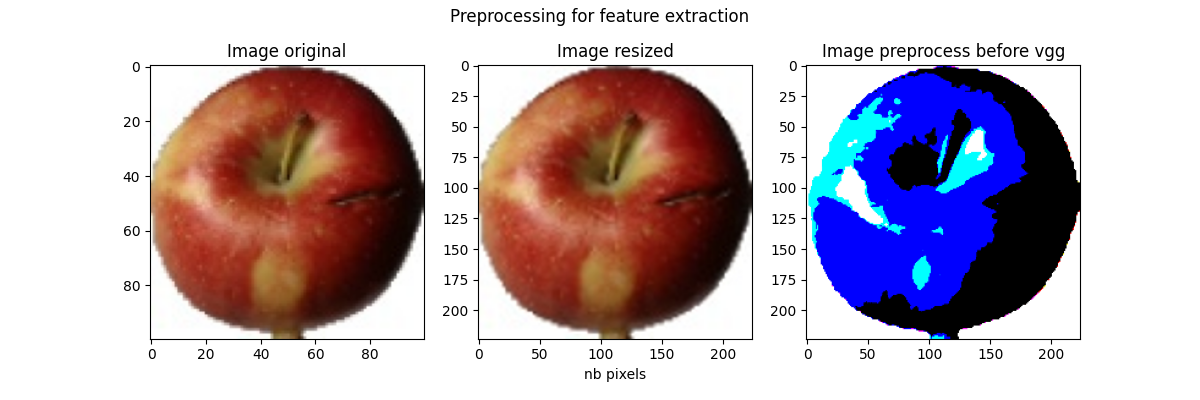

In [19]:
fig,axes=plt.subplots(ncols=3,figsize=(12,4))
img_init=Image.open(io.BytesIO(imagetest))

axes[0].imshow(img_init)
img_resize=img_init.resize([224, 224])
axes[1].imshow(img_resize)
prepimage = preprocess_input(img_to_array(img_resize))
axes[2].imshow(prepimage)

axes[0].set_title('Image original')
axes[1].set_xlabel('nb pixels')
axes[1].set_title('Image resized')
axes[2].set_title('Image preprocess before vgg')
fig.suptitle('Preprocessing for feature extraction')
plt.show()
%matplot plt

## Extraction de features

In [9]:
model.summary()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [12]:
model = VGG16(include_top=False,pooling='max')


bc_model_weights = sc.broadcast(model.get_weights())
model.summary()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [13]:
# Trouvé: https://docs.databricks.com/_static/notebooks/deep-learning/deep-learning-transfer-learning-keras.html
def model_fn():
    """
  Returns a vgg16 model with top layer removed and broadcasted pretrained weights.
  """
    model_ = VGG16(weights=None,include_top=False,pooling='max')
    model_.set_weights(bc_model_weights.value)
    return model_
def preprocess(content):
  """
  Preprocesses raw image bytes for prediction.
  """
  img = Image.open(io.BytesIO(content)).resize([224, 224])
  arr = img_to_array(img)
  return preprocess_input(arr)

def featurize_series(model, content_series):
  """
  Featurize a pd.Series of raw images using the input model.
  :return: a pd.Series of image features
  """
  input = np.stack(content_series.map(preprocess))
  preds = model.predict(input)
  # For some layers, output features will be multi-dimensional tensors.
  # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
  output = [p.flatten() for p in preds]
  return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
  '''
  This method is a Scalar Iterator pandas UDF wrapping our featurization function.
  The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
  :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
  '''
  # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
  # for multiple data batches.  This amortizes the overhead of loading big models.
  model = model_fn()
  for content_series in content_series_iter:
    yield featurize_series(model, content_series)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1662488060805_0001/container_1662488060805_0001_01_000001/pyspark.zip/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

In [24]:
features_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[path: string, label: string, features: array<float>]

In [14]:
features_df = imgS3.repartition(16).select(col("path"),col("label"), featurize_udf("content").alias("features"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
features_df.show(3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------+--------------------+
|                path| label|            features|
+--------------------+------+--------------------+
|s3a://p8-bucket-m...| pomme|[0.0, 0.0, 0.0, 0...|
|s3a://p8-bucket-m...|avocat|[0.0, 0.0, 0.0, 7...|
|s3a://p8-bucket-m...|avocat|[0.0, 0.0, 0.0, 7...|
+--------------------+------+--------------------+
only showing top 3 rows

In [34]:
features_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[path: string, label: string, features: array<float>]

In [15]:
vector_udt = udf(lambda x: Vectors.dense(x), VectorUDT())
features_df = features_df.select(col("path"), col("label"), vector_udt(features_df["features"]).alias("features_sparktypes"))
features_df.show(3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------+--------------------+
|                path| label| features_sparktypes|
+--------------------+------+--------------------+
|s3a://p8-bucket-m...| pomme|[60.6305160522460...|
|s3a://p8-bucket-m...|banane|[4.01261711120605...|
|s3a://p8-bucket-m...| pomme|[8.80388259887695...|
+--------------------+------+--------------------+
only showing top 3 rows

In [9]:
#features_df = features_df.select(col("path"), col("label"), vector_udt("features").alias("features_sparktypes"))
#features_df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------+--------------------+
|                path| label| features_sparktypes|
+--------------------+------+--------------------+
|s3a://p8-bucket-m...| pomme|[0.0,0.0,0.0,0.0,...|
|s3a://p8-bucket-m...| pomme|[0.0,0.0,0.0,0.0,...|
|s3a://p8-bucket-m...| pomme|[0.0,0.0,0.0,0.44...|
|s3a://p8-bucket-m...| pomme|[0.0,0.0,0.0,1.06...|
|s3a://p8-bucket-m...|banane|[0.0,0.0,2.106489...|
+--------------------+------+--------------------+
only showing top 5 rows

## Scaling et PCA

In [16]:
scaler = StandardScaler(inputCol="features_sparktypes", outputCol="scaledFeatures",withStd=True, withMean=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
t0 = time()
model =scaler.fit(features_df)
print(f'Temps de calcul scaling {time()-t0} s')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Temps de calcul scaling 14.698511600494385 s

In [18]:
t0 = time()
features_df = model.transform(features_df)
print(f'Temps de calcul scaling {time()-t0} s')
features_df.show(3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Temps de calcul scaling 0.13642597198486328 s
+--------------------+------+--------------------+--------------------+
|                path| label| features_sparktypes|      scaledFeatures|
+--------------------+------+--------------------+--------------------+
|s3a://p8-bucket-m...| pomme|[60.6305160522460...|[2.78719159822297...|
|s3a://p8-bucket-m...|banane|[4.01261711120605...|[0.18446045700158...|
|s3a://p8-bucket-m...| pomme|[8.80388259887695...|[0.40471546688117...|
+--------------------+------+--------------------+--------------------+
only showing top 3 rows

In [19]:
pca = PCA(k=20, inputCol="scaledFeatures", outputCol="pca_features")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
features_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[path: string, label: string, features_sparktypes: vector, scaledFeatures: vector]

In [20]:
model_pca = pca.fit(features_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
variance_explained = model_pca.explainedVariance.cumsum()
variance_explained

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([0.24454678, 0.38080841, 0.47962868, 0.57086178, 0.6466249 ,
       0.69719679, 0.74380569, 0.77786291, 0.80947724, 0.83706606,
       0.86417608, 0.89102921, 0.91421271, 0.93333077, 0.95122307,
       0.96849738, 0.98233176, 0.99355754, 1.        , 1.        ])

In [38]:
fig=plt.figure(figsize=(10,5))
plt.plot(np.arange(1,
                   len(variance_explained) + 1),
         variance_explained * 100,
         'o:',
         color='red')
plt.xlim(0, 21)
plt.ylim(0, 100)
plt.xticks(range(21))
plt.grid()
plt.xlabel('dimension PCA')
plt.ylabel('Variance expliquee %')
plt.title('Variance expliquee en fonction du nombre de dimension')
plt.bar(np.arange(1,
                  len(variance_explained) + 1),
        variance_explained * 100,
        color='darkred')
plt.grid(True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

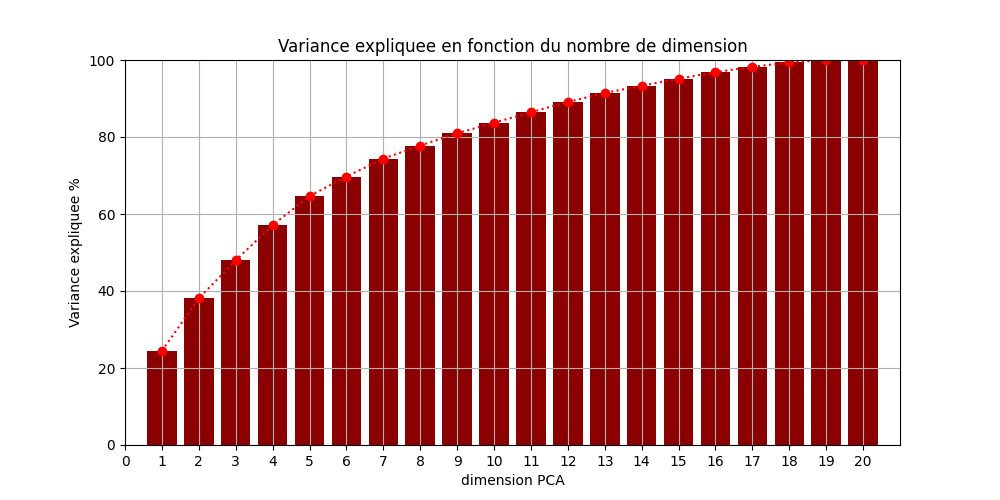

In [39]:
%matplot plt

In [41]:
img_s3_pca = model_pca.transform(features_df).select(["path", "label", "pca_features"])
img_s3_pca.show(3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------+--------------------+
|                path| label|        pca_features|
+--------------------+------+--------------------+
|s3a://p8-bucket-m...| pomme|[-18.827460106368...|
|s3a://p8-bucket-m...|banane|[5.60933227696263...|
|s3a://p8-bucket-m...| pomme|[-10.233328862411...|
+--------------------+------+--------------------+
only showing top 3 rows

## Enregistrement du modèle en parquet sur S3 
En csv également 

In [42]:
img_s3_pca.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

20

In [43]:
img_s3_pca.write.format("parquet").mode('overwrite').save("s3a://p8-bucket-mb/result_pca_p8.parquet")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
df_pca=img_s3_pca.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [53]:
xpca1=df_pca.pca_features.apply(lambda x :x[0])
xpca2=df_pca.pca_features.apply(lambda x :x[1])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
df_pca_plot=pd.DataFrame(df_pca.label)
df_pca_plot['Xpca1']=xpca1
df_pca_plot['Xpca2']=xpca2


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [62]:
pomme=df_pca_plot[(df_pca_plot.label=='pomme')]
banane=df_pca_plot[(df_pca_plot.label=='banane')]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [63]:
banane

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

     label     Xpca1      Xpca2
1   banane  5.609332 -13.719989
3   banane  4.540371 -20.296162
5   banane  4.836088   6.767093
7   banane  7.066173 -16.125923
9   banane  4.279992 -16.323736
11  banane  6.361373 -15.839203
13  banane  7.663739 -15.055537
15  banane  6.610168 -11.962853
17  banane  7.152389 -14.746481
19  banane  5.531794   7.518612

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

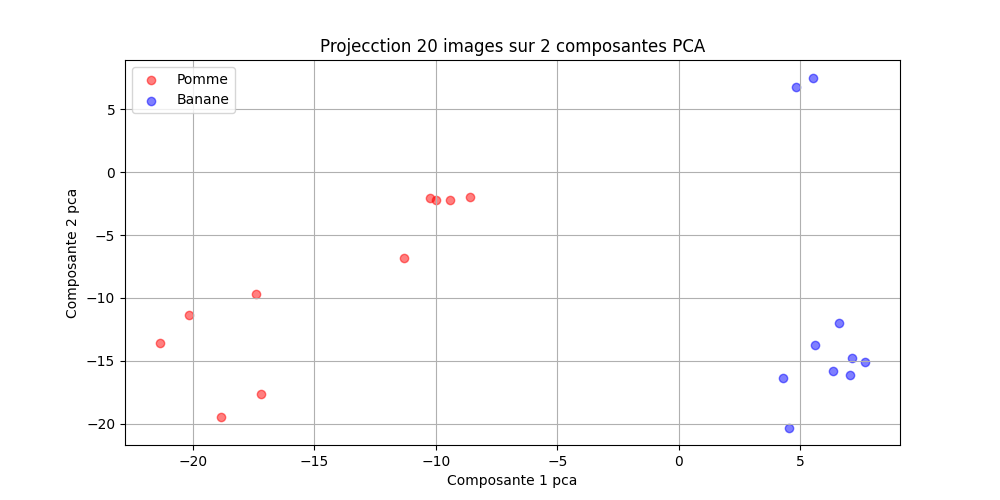

In [73]:
fig=plt.figure(figsize=(10,5))
plt.scatter(pomme.Xpca1, pomme.Xpca2, c='red', alpha=0.5,label='Pomme')
plt.scatter(banane.Xpca1, banane.Xpca2, c='blue', alpha=0.5,label='Banane')
plt.legend()
plt.show()

plt.grid(True)

plt.title('Projecction 20 images sur 2 composantes principales PCA')
plt.xlabel('Composante 1 pca')
plt.ylabel('Composante 2 pca')
%matplot plt